#Graphs & Social Networks &mdash; lab material
This notebook contains a definition of a python class *Graph*, containing functions described during labs.

Package import.

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
import time
from collections import deque

## Simple functions from the first classes
This is left just as an example (to compare the behaviour).

In [ ]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

## Class *Graph*

In [ ]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.full(shape=(n, n), fill_value=1e8, dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        for u in range(n):
            matrix[u][u] = 0
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self):
      """
      Plots the graph using networkxx package.
      """
      G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def random_bipartite_graph(m, n, p):
        """
        Creates a random bipartite graph G(m, n, p) model.
        m: number of vertices in the first partition.
        n: number of vertices in the second partition.
        p: probability of an edge between vertices from different partitions.
        """
        bipartite_graph = Graph()
        for i in range(1, m + n + 1):
            bipartite_graph.add_vertex(i)

        for u in range(1, m + 1):
            for w in range(m + 1, m + n + 1):
                if random() < p:
                    bipartite_graph.add_edge([u, w])
        return bipartite_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v, visited=None):
        """
        Performs a pre-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            print(v, end=" ")
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.preorder(neighbor, visited)

    def postorder(self, v, visited=None):
        """
        Performs a post-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.postorder(neighbor, visited)
            print(v, end=" ")

    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by the set of vertices V.
        """
        subgraph = Graph()
        for v in V:
            subgraph.add_vertex(v)
            for w in self.graph[v]:
                if w in V:
                    subgraph.add_arc([v, w])
        return

    def ConnectedComponentsGraphs(self):
        """
        Returns a list of graphs, where each graph represents a connected component.
        Uses the existing connected_components method to find vertex sets.
        """
        components_vertex_sets = self.connected_components()
        list_of_component_graphs = []

        for component_set in components_vertex_sets[1:]:
            component_graph = Graph()
            for u in component_set:
                #component_graph.add_vertex(u)
                #for v in self.graph.get(u, []):
                #    component_graph.add_arc([u, v])
                component_graph.graph[u] = self.graph[u]
            list_of_component_graphs.append(component_graph)

        return list_of_component_graphs

    def distance(self, v):
      """
      Computes the distance from vertex v to all other reachable vertices in the graph.
      Uses BFS algorithm.
      Result is given as a dictionary of distances
      """
      dist = {v: 0}
      queue = [v]
      while queue:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    def ConnectedComponentsBFS(self):
      """
      Looks for connected components of undirected graph using BFS.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """

      def BFS(u):
        """
        Breadth first search (as internal method).
        """
        queue = [u]
        while queue:
          current_vertex = queue.pop(0)
          for neighbor in self.graph[current_vertex]:
            if neighbor not in VT[0]:      # neighbor - not visited yet
              VT[0].add(neighbor)          # already visited
              VT[-1].add(neighbor)         # neighbor - in the last connected component
              queue.append(neighbor)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # starting point of new connected component
          BFS(v)
      return VT

    def floydWarshall(self):
      dist = self._dict_to_matrix(self.graph)
      V = len(dist)

      for k in range(V):
          for i in range(V):
              for j in range(V):
                  if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]

      return V

    def TopologicalSort(self):
      """
      Topological sort of a graph.
      """
      in_degree = {v: 0 for v in self.graph}
      for u in self.graph:
          for v in self.graph[u]:
              in_degree[v] += 1

      # Queue for vertices with 0 in-degree
      queue = deque([v for v in self.graph if in_degree[v] == 0])
      topo_order = []

      while queue:
          u = queue.popleft()
          topo_order.append(u)

          # Decrease in-degree for adjacent vertices
          for v in self.graph[u]:
              in_degree[v] -= 1
              if in_degree[v] == 0:
                  queue.append(v)

      if len(topo_order) != len(self.graph):
          raise ValueError("Graph has cycles, topological sort not possible")

      return topo_order



## Use of code

## Homework

Write a preorder(v) and postorder(v) function that will print trees (e.g. generated from Prüfer's code) in preorder or (respectively) postorder order, starting from vertex v.

In [ ]:
tree = Graph.tree_from_Prufer("3 5 5 5")

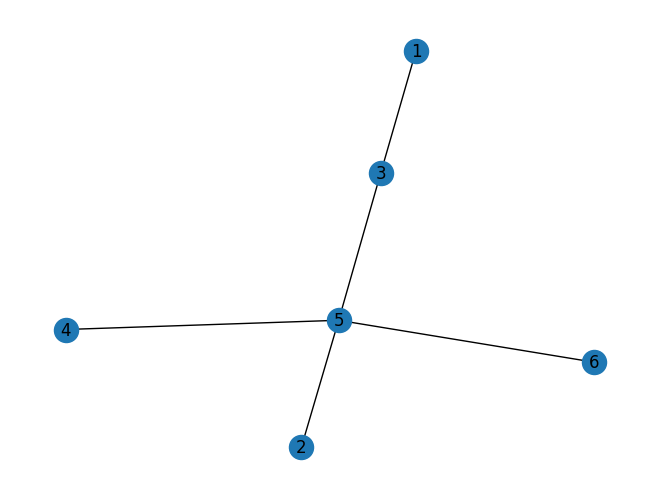

In [ ]:
tree.plot()

In [ ]:
tree.preorder(5)

5 2 3 1 4 6 

In [ ]:
tree.postorder(5)

2 1 3 4 6 5 

The ConnectedComponents function shown during classes returns a list of vertex sets. Write a ConnectedComponentsGraphs() function that returns a list of graphs — connected components of the graph on which is run. One can (worthwhile) use the (ready) ConnectedComponents function.

In [ ]:
graph1 = Graph.random_graph(10, 1/3)
for i, graph in enumerate(graph1.ConnectedComponentsGraphs()):
  print("Connected Component " + str(i+1) + ":")
  print(graph)

Connected Component 1:
1: 4
2: 6
3: 5 6 8 9
4: 1 9
5: 3 7 8
6: 2 3 9 10
7: 5 9
8: 3 5
9: 3 4 6 7 10
10: 6 9



Write a random_bipartite_graph(m,n, p)  function that will generate a bipartite random graph with m+n vertices (a subgraph of the graph K(m,n ) in which each possible pair of vertices is connected by an edge independently, with probability p.

In [ ]:
random_bipartite_graph = Graph.random_bipartite_graph(3,4,0.3)
print(random_bipartite_graph)

1: 6
2: 5 7
3: 6 7
4:
5: 2
6: 1 3
7: 2 3



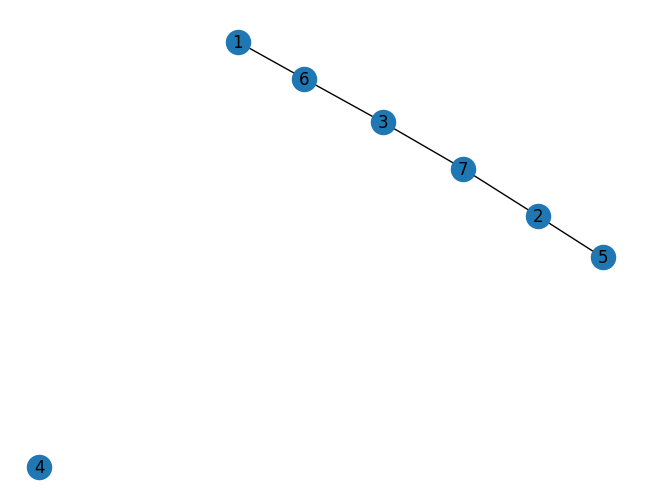

In [ ]:
random_bipartite_graph.plot()

## Distances in a graph

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-22 19:05:38--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-22 19:05:38--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt.5’

weighted0.txt.5     100%[===================>]     114  --.-KB/s    in 0s      

2025-11-22 19:05:38 (6.80 MB/s) - ‘weighted0.txt.5’ saved [114/114]



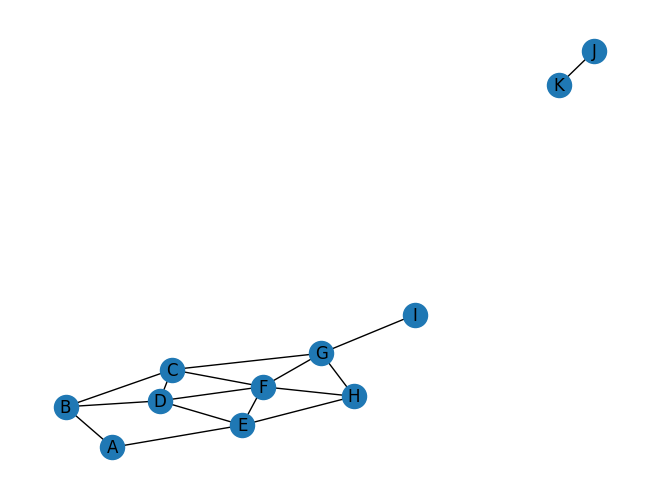

In [ ]:
graph1 = Graph.from_edges("weighted0.txt")
graph1.add_edge(["K", "J"])
graph1.plot()

In [ ]:
dist = graph1.distance("A")

print(dist)

{'A': 0, 'B': 1, 'E': 1, 'C': 2, 'D': 2, 'F': 2, 'H': 2, 'G': 3, 'I': 4}


## Millgrams experiment - Small World Phenomenon
We will look whether G(n,p) (eg. G(4000, 1/600)) is a good illustration

In [ ]:
n = 4000
p = 1/600
rgraph = Graph.random_graph(n, p)
graph = rgraph.ConnectedComponentsGraphs()[0]
print(len(graph.vertices()))

3998


In [ ]:
md = {}
ecc = {}
for v in graph.vertices():
  dist = graph.distance(v)
  md[v] = sum(dist.values())/len(dist)
  ecc[v] = max(dist.values())

print("Average distance: ", sum(md.values())/len(md))
print("Radius: ", min(ecc.values()))
print("Diameter: ", max(ecc.values()))

Average distance:  4.589811914461483
Radius:  6
Diameter:  9


# Task 5

With a large number of vertices, depth-first search encounters the problem of recursion depth. Prepare the ConnectedComponentsBFS function, which will use breadth-first search to determine strongly connected components. Alternatively, you can try to write DFS without using recursive calls.

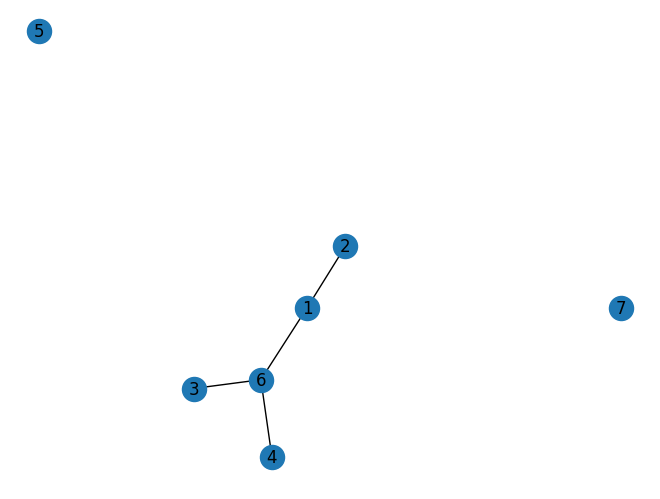

4
[{1, 2, 3, 4, 5, 6, 7}, {1, 2, 3, 4, 6}, {5}, {7}]


In [ ]:
graph_bfs = Graph.random_graph(7, 1/5)
graph_bfs.plot()

print(len(graph_bfs.ConnectedComponentsBFS()))
print(graph_bfs.ConnectedComponentsBFS())


The example presented during classes (simulation of a small-world phenomenon) can be performed more efficiently using the Floyd-Warshal algorithm (for shortest paths). Check how much faster this method of implementation is.

In [ ]:
import time
md = {}
ecc = {}
graph = Graph.random_graph(100, 1/25)
start_time = time.time()
dist = graph.floydWarshall()

print("Runtime Floyd-Warshall: ", time.time() - start_time)

Runtime Floyd-Warshall:  1.602435827255249


Write the TopologicalSort function, which performs topological sorting of a directed graph (a slightly more difficult task, but the pseudocode was given in the lecture, and all the necessary elements — shown during classes).

DAG graph:


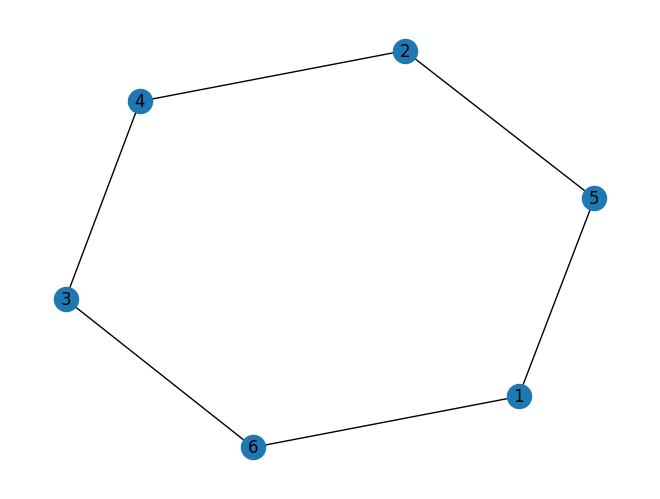

Topological order: [5, 6, 3, 1, 4, 2]


In [ ]:
dag_dict = {
        1: [],
        2: [],
        3: [4],
        4: [2],
        5: [1, 2],
        6: [3, 1]
    }

dag = Graph.from_dict(dag_dict)
print("DAG graph:")
dag.plot()

topo_order = dag.TopologicalSort()
print(f"Topological order: {topo_order}")

### Part 4 (Connected components via DFS)

In [ ]:
graph1 = Graph.random_graph(100, 1/25)
#print(graph1)

In [ ]:
print(len(graph1.connected_components()))
print(graph1.connected_components())

### Part 3 (Prufer codes)

In [ ]:
%%writefile tree1.txt
1 3
3 5
2 5
4 5
6 5

In [ ]:
tree1 = Graph.from_edges("tree1.txt")

In [ ]:
print(tree1)

In [ ]:
print(tree1.Prufer())

In [ ]:
print(Graph.tree_from_Prufer("3 5 5 5"))

In [ ]:
print(Graph.tree_from_Prufer("5 4 3 1"))

In [ ]:
print(Graph.tree_from_Prufer("1 1 1 2 3"))

### Part2

In [ ]:
%%writefile edges.txt
a b
b c
b d
d
d c
e
f


In [ ]:
%cat edges.txt

In [ ]:
graph2 = Graph.from_edges("edges.txt")
print(graph2)

In [ ]:
graph2.to_neighbourlist("neighbourhood.txt")

In [ ]:
%cat "neighbourhood.txt"

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

In [ ]:
graph3 = Graph.from_edges("weighted0.txt")
print(graph3)

In [ ]:
# it works as well
!wget https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/weighted0.txt

In [ ]:
graph4 = Graph.random_graph(10, 1/3)
print(graph4)

In [ ]:
print(Graph.cycle(6))

### Part1

In [ ]:
vertices = ["a", "b", "c", "d"]
matrix = np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,0,1]])
print(vertices)
print(matrix)
print("---------------------------")
print_matrix(vertices, matrix)
print("---------------------------")
print_matrix(None,matrix)

In [ ]:
graph_dict = {
  "a": ["b"],
  "b": ["a", "c"],
  "c": ["b", "d"],
  "d": ["c"]
}
print(graph_dict)
print("---------------------------")
print_dict(graph_dict)

In [ ]:
graph1 = Graph.from_matrix(matrix, vertices)
print(graph1)

In [ ]:
print(Graph(graph_dict))  # the same result

In [ ]:
print(graph1.vertices())

In [ ]:
print(graph1.matrix())

In [ ]:
graph1.add_vertex("e")
print(graph1)

In [ ]:
graph1.add_edge(["e", "f"])
print(graph1)

In [ ]:
graph1.add_arc(["e", "a"])  # breaking the symmetry
print(graph1)

In [ ]:
graph1.add_edge(["e", "a"])  # restoring the symmetry
print(graph1)

In [ ]:
graph1.add_edge(["e", "f"]) # do nothing, an edge already exists
print(graph1)

In [ ]:
graph1.del_vertex("f")  # removing a vertex
print(graph1)

In [ ]:
graph1.add_edge(["e", "e"]) # an error

In [ ]:
graph1.add_arc(["e", "e"]) # OK - loops are allowed in digraphs
print(graph1)

In [ ]:
print(Graph.cycle(6))